# LightGBM

In [2]:
# pip install xgboost

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from functools import partial
from pprint import pprint
import numpy as np
from hyperopt.pyll import scope, stochastic
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils import check_random_state

In [11]:
seed=623

In [4]:
data = pd.read_csv('data_clear.csv', index_col=0)
for col in data.select_dtypes('object').columns:
    if col not in ['user']:
        lbl = LabelEncoder()
        data[col] = lbl.fit_transform(data[col].astype(str))

In [9]:
df_train = data[~data['label'].isnull()]
test_fea = data[data['label'].isnull()].drop(columns=['label'], axis=1)
test_label = pd.read_csv('test_label_new.csv', index_col=0)
df_test = pd.merge(test_label, test_fea, on='user')
test.head()

,user,label,login_cnt_period1_x,province_x,city_x,sex_sex_x,sex_provider_x,sex_level_x,sex_verified_x,sex_regist_type_x,...,city_op2_cnt_mean,city_service1_cnt_mean,city_service1_amt_mean,city_agreement_total_mean,city_login_cnt_avg_mean,city_balance_avg_mean,city_balance2_mean,city_product1_amount_mean,city_product3_amount_mean,city_product7_cnt_mean
0,Train_00003,0,0.007184,28,291,0,2,2,0,3,...,0.024291,0.000892,0.002189,0.295974,0.020448,0.427431,0.390221,0.058535,0.027340,0.053021
1,Train_00004,0,0.009401,29,108,0,2,1,0,3,...,0.024203,0.002883,0.003845,0.294743,0.021034,0.449188,0.436456,0.066038,0.041105,0.051695
2,Train_00007,0,0.142887,11,5,0,0,2,0,7,...,0.027596,0.001651,0.001858,0.354248,0.024333,0.478986,0.338406,0.126812,0.188406,0.055025
3,Train_00015,1,0.003438,24,151,0,0,1,0,1,...,0.024375,0.006062,0.003518,0.327722,0.019835,0.473709,0.413615,0.061033,0.018779,0.052674
4,Train_00019,0,0.015655,10,200,0,0,2,0,1,...,0.023225,0.001808,0.003075,0.336261,0.019004,0.472673,0.401935,0.116567,0.132440,0.057225


In [10]:
y_train = df_train['label']
X_train = df_train.drop(columns=['label','user'], axis=1)

y_test = df_test['label']
X_test = df_test.drop(columns=['label', 'user'], axis=1)

In [12]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [48]:
# specify your configurations as a dict
params = {}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval)
#                 early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91978
[LightGBM] [Info] Number of data points in the train set: 38225, number of used features: 745
[LightGBM] [Info] Start training from score 0.246802


In [49]:
test = pd.DataFrame({'y_pred': y_pred,
                    'y_test': y_test})

In [50]:
test.head()

,y_pred,y_test
0,0.164496,0
1,0.304142,0
2,0.112178,0
3,0.365508,1
4,0.309863,0


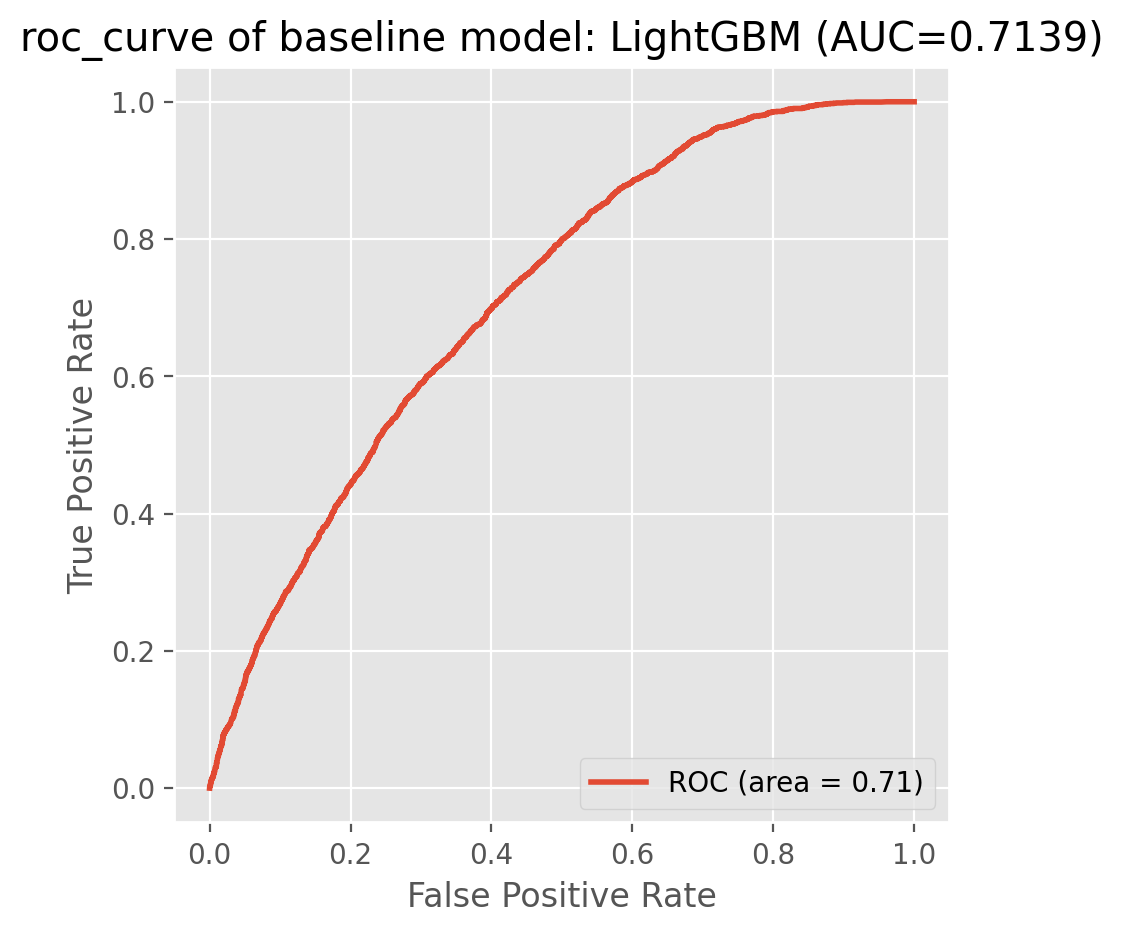

In [51]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test['y_test'],test['y_pred']) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model: LightGBM ',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
# plt.savefig("baseline_roc.png")

# XGBoost

In [65]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [68]:
# specify parameters via map
param = {'objective':'binary:logistic' }
num_round = 20
bst = xgb.train(param, dtrain, num_round)
# make prediction
y_pred = bst.predict(dtest)

[01:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
test = pd.DataFrame({'y_pred': y_pred,
                    'y_test': y_test})

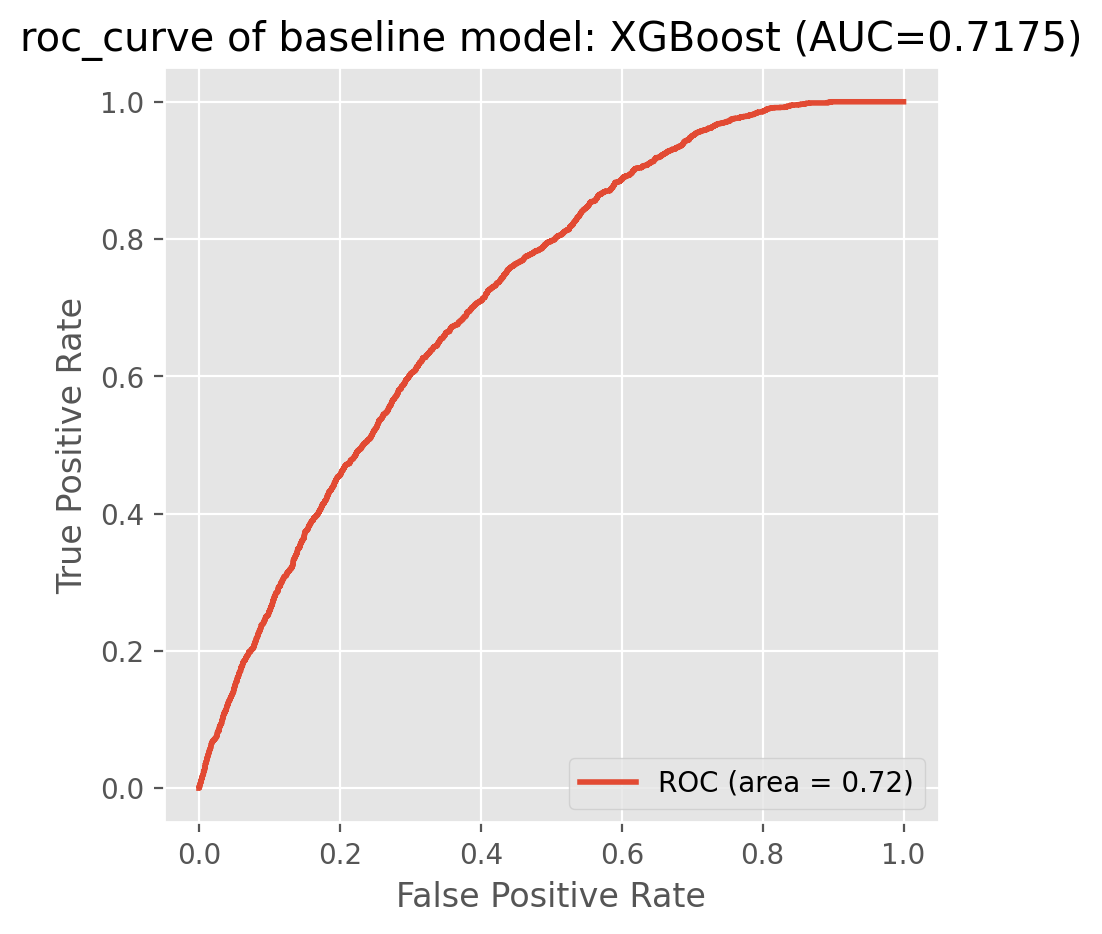

In [70]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test['y_test'],test['y_pred']) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model: XGBoost ',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
# plt.savefig("baseline_roc.png")